In [117]:
pip install pandas scikit-learn numpy



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install matplotlib



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from urllib.parse import urlparse
import numpy as np
from math import log2
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Read the data

In [120]:
df = pd.read_csv('combined_df.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,url,label
0,www.usaozsazps.com/information,1
1,awrs.cl/wp-content/themes/form/bill.charged.html,1
2,ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...,1
3,wwxhajudjgwjklckvzgs7.firebaseapp.com/,1
4,roomclip.jp,0
...,...,...
91721,optikgeneral.com/Webmail/12/Webmail/webmail.php,1
91722,thegioididong.com,0
91723,pressks.com,0
91724,68.178.168.47/Empresarial/,1


In [121]:
!pip install python-whois



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [122]:
import pandas as pd
from urllib.parse import urlparse
import re

from datetime import datetime
import whois  # You need to install python-whois package for this to work



# Helper function to calculate the number of times each special character appears in the URL
def count_chars(url, char_list):
    return {f"num_{char}_url": url.count(char) for char in char_list}

# Function to check if an email is present in the URL
def check_email_in_url(url):
    return 1 if "@" in url else 0

# Calculate the length of the top-level domain (TLD)
def tld_length(url):
    domain = urlparse(url).netloc
    try:
        return len(domain.split('.')[-1])  # Assuming the last part after the last dot is the TLD
    except IndexError:
        return 0

# New function to check if "&" is greater than "=" in the URL
def amp_greater_than_equal(url):
    num_amp = url.count("&")
    num_equal = url.count("=")
    return 1 if num_amp > num_equal else 0

# Updated function to extract features from URLs in a DataFrame
def extract_features_from_urls(df):
    def get_features(url):
        special_chars = ['.', '-', '_', '/', '?', '=', '@', '&', '!', ' ', '~', ',', '+', '*', '#', '$', '%']
        features = count_chars(url, special_chars)
        features['length_url'] = len(url)
        features['email_in_url'] = check_email_in_url(url)
        features['num_tld_url'] = tld_length(url)
        # Add the new feature
        features['amp_greater_than_equal'] = amp_greater_than_equal(url)
        return features
    
    # Apply the get_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(get_features(x)))
    return pd.concat([df, features_df], axis=1)


In [123]:
#First, apply URL features extraction
df_features = extract_features_from_urls(df)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [124]:
def domain_features(url):
    first_url = "http://" + url
    parsed_url = urlparse(first_url)
    domain = parsed_url.netloc

    if domain.startswith("www."):
        domain = domain[4:]
    else:
        domain = domain

    # Calculate the number of dots in the domain
    num_dots_dom = domain.count('.')

    # Calculate the number of hyphens in the domain
    num_hyph_dom = domain.count('-')

    # Calculate the number of underscores in the domain
    num_undeline_dom = domain.count('_')

    # Count the number of vowels in the domain
    num_vowels_dom = sum(1 for char in domain if char in 'aeiouAEIOU')

    # Calculate the length of the domain
    length_dom = len(domain)

    # Check if the domain is in IP format
    dom_in_ip = 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", domain) else 0

    # Check for the presence of "server" or "client" in the domain
    server_client_dom = 1 if 'server' in domain or 'client' in domain else 0

    # try:
    #     domain_info = whois.whois(domain)
    #     creation_date = domain_info.creation_date
    #     expiration_date = domain_info.expiration_date
        
    #     # Normalize creation and expiration dates if they are in list format or other
    #     if isinstance(creation_date, list):
    #         creation_date = creation_date[0]
    #     if isinstance(expiration_date, list):
    #         expiration_date = expiration_date[0]
        
    #     # Calculate domain age in days
    #     if creation_date and expiration_date:
    #         domain_age_days = (expiration_date - creation_date).days
    #     else:
    #         domain_age_days = None
    # except Exception as e:
    #     domain_age_days = None  # In case of any error, set domain age to None

    # Compile all features into a dictionary
    features = {
        'num_dots_dom': num_dots_dom,
        'num_hyph_dom': num_hyph_dom,
        'num_undeline_dom': num_undeline_dom,
        'num_vowels_dom': num_vowels_dom,
        'length_dom': length_dom,
        'dom_in_ip': dom_in_ip,
        'server_client_dom': server_client_dom,
        #'domain_age_days': domain_age_days,  # Add domain age in days to the features
    }
    
    return features


def features_from_domain(df):
    # Apply the domain_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(domain_features(x)))
    return pd.concat([df, features_df], axis=1)

In [125]:
#Then, apply domain features extraction on the same DataFrame
df_features = features_from_domain(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [47]:
# Print the "url" column from the first row
print("First URL in the DataFrame:", df_features.iloc[0]["url"])

# Function to extract domain from URL
def extract_domain(url):
    parsed_url = urlparse(url)
    print(parsed_url)
    # print(parsed_url)
    domain = parsed_url.path
    print(domain)
    if domain.startswith("www."):
        return domain[4:]
    else:
        return domain
    
# Extracting domain from the URL in the first row
first_url = df_features.iloc[0]["url"]
first_url = "http://" + first_url
domain = extract_domain(first_url)

# Printing the extracted domain
print("Domain from the first URL:", domain)

First URL in the DataFrame: www.usaozsazps.com/information
ParseResult(scheme='http', netloc='www.usaozsazps.com', path='/information', params='', query='', fragment='')
/information
Domain from the first URL: /information


In [99]:
# Assuming df is your DataFrame
import pandas as pd

# Check if any value in the "damage" column is not equal to 0
non_zero_damage = df_features['num_hyph_dom'] != 0

# Count the number of entries with non-zero values in the "damage" column
num_non_zero_damage = non_zero_damage.sum()

if num_non_zero_damage > 0:
    print("There are entries with values different from 0 in the 'damage' column.")
    print("Number of such entries:", num_non_zero_damage)
else:
    print("There are no entries with values different from 0 in the 'damage' column.")


There are entries with values different from 0 in the 'damage' column.
Number of such entries: 22488


In [126]:
def extract_pathname_features(url):
    """
    Extracts features from the pathname of a URL.
    """
    first_url = "http://" + url
    pathname = urlparse(first_url).path

    features = {
        'num_dots_path': pathname.count('.'),
        'num_hyph_path': pathname.count('-'),
        'num_undeline_path': pathname.count('_'),
        'num_slash_path': pathname.count('/'),
        'num_question_path': pathname.count('?'),
        'num_equal_path': pathname.count('='),
        'at_sign_path': pathname.count('@'),
        'num_and_path': pathname.count('&'),
        'num_exclamation_path': pathname.count('!'),
        'num_space_path': pathname.count(' '),
        'tilde_path': pathname.count('~'),
        'num_comma_path': pathname.count(','),
        'num_plus_path': pathname.count('+'),
        'num_asterisk_path': pathname.count('*'),
        'num_hash_path': pathname.count('#'),
        'num_dollar_path': pathname.count('$'),
        'num_percent_path': pathname.count('%'),
        'length_path': len(pathname)
    }
    
    return features

def features_from_pathname(df):
    """
    Applies the extract_pathname_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_pathname_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_pathname_features(x)))
    return pd.concat([df, features_df], axis=1)


In [127]:
df_features = features_from_pathname(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [103]:
# Assuming df is your DataFrame
import pandas as pd

# Check if any value in the "damage" column is not equal to 0
non_zero_damage = df_features['num_greater_path'] != 0

# Count the number of entries with non-zero values in the "damage" column
num_non_zero_damage = non_zero_damage.sum()

if num_non_zero_damage > 0:
    print("There are entries with values different from 0 in the 'damage' column.")
    print("Number of such entries:", num_non_zero_damage)
else:
    print("There are no entries with values different from 0 in the 'damage' column.")


There are no entries with values different from 0 in the 'damage' column.


In [128]:
def extract_filename_features(url):
    """
    Extracts features from the filename of a URL.
    """
    first_url = "http://" + url
    # Parse the URL to get the path
    path = urlparse(first_url).path
    # Extract the filename (assuming the filename is the last part of the path)
    filename = path.split('/')[-1] if '/' in path else path
    
    features = {
        'num_dots_file': filename.count('.'),
        'num_hyph_file': filename.count('-'),
        'num_undeline_file': filename.count('_'),
        'num_equal_file': filename.count('='),
        'at_sign_file': filename.count('@'),
        'num_and_file': filename.count('&'),
        'num_exclamation_file': filename.count('!'),
        'num_space_file': filename.count(' '),
        'tilde_file': filename.count('~'),
        'num_comma_file': filename.count(','),
        'num_plus_file': filename.count('+'),
        'num_percent_file': filename.count('%'),
        'length_file': len(filename)
    }
    
    return features

def features_from_filename(df):
    """
    Applies the extract_filename_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_filename_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_filename_features(x)))
    return pd.concat([df, features_df], axis=1)

In [129]:
df_features = features_from_filename(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [112]:
# Assuming df is your DataFrame
import pandas as pd

# Check if any value in the "damage" column is not equal to 0
non_zero_damage = df_features['num_param'] != 0

# Count the number of entries with non-zero values in the "damage" column
num_non_zero_damage = non_zero_damage.sum()

if num_non_zero_damage > 0:
    print("There are entries with values different from 0 in the 'damage' column.")
    print("Number of such entries:", num_non_zero_damage)
else:
    print("There are no entries with values different from 0 in the 'damage' column.")


KeyError: 'num_param'

In [130]:
from urllib.parse import urlparse, parse_qs
import pandas as pd

def extract_parameters_features(url):
    """
    Extracts features from the parameters of a URL.
    """
    first_url = "http://" + url
    query_string = urlparse(first_url).query
    params = parse_qs(query_string)
    
    # Counting the occurrences of various symbols in the entire query string
    features = {
        'num_dots_param': query_string.count('.'),
        'num_hyph_param': query_string.count('-'),
        'num_undeline_param': query_string.count('_'),
        'num_slash_param': query_string.count('/'),
        'num_questionmark_param': query_string.count('?'),
        'num_equal_param': query_string.count('='),
        'at_sign_param': query_string.count('@'),
        'num_and_param': query_string.count('&'),
        'num_exclamation_param': query_string.count('!'),
        'num_space_param': query_string.count(' '),
        'tilde_param': query_string.count('~'),
        'num_comma_param': query_string.count(','),
        'num_plus_param': query_string.count('+'),
        'num_asterisk_param': query_string.count('*'),
        'num_dollar_param': query_string.count('$'),
        'num_percent_param': query_string.count('%'),
        'length_param': len(query_string),
        'tld_in_param': int(any(part.endswith(('.com', '.org', '.net', '.edu', '.gov')) for part in query_string.split('&'))),
        'num_param': len(params)
    }
    
    return features

def features_from_parameters(df):
    """
    Applies the extract_parameters_features function to each URL in a DataFrame and returns the DataFrame with added features.
    """
    # Apply the extract_parameters_features function to each URL in the DataFrame
    features_df = df['url'].apply(lambda x: pd.Series(extract_parameters_features(x)))
    return pd.concat([df, features_df], axis=1)

In [131]:
df_features = features_from_parameters(df_features)

print(df_features)

                                                     url  label  num_._url  \
0                         www.usaozsazps.com/information      1          2   
1       awrs.cl/wp-content/themes/form/bill.charged.html      1          3   
2      ipfs.eth.aragon.network/ipfs/bafybeifg3yzh6ekg...      1          3   
3                 wwxhajudjgwjklckvzgs7.firebaseapp.com/      1          2   
4                                            roomclip.jp      0          1   
...                                                  ...    ...        ...   
91721    optikgeneral.com/Webmail/12/Webmail/webmail.php      1          2   
91722                                  thegioididong.com      0          1   
91723                                        pressks.com      0          1   
91724                         68.178.168.47/Empresarial/      1          3   
91725                                usps.comhelpom.com/      1          2   

       num_-_url  num___url  num_/_url  num_?_url  num_=_url  n

In [116]:
# Assuming df is your DataFrame
import pandas as pd

# Check if any value in the "damage" column is not equal to 0
non_zero_damage = df_features['num_param'] != 0

# Count the number of entries with non-zero values in the "damage" column
num_non_zero_damage = non_zero_damage.sum()

if num_non_zero_damage > 0:
    print("There are entries with values different from 0 in the 'damage' column.")
    print("Number of such entries:", num_non_zero_damage)
else:
    print("There are no entries with values different from 0 in the 'damage' column.")


There are entries with values different from 0 in the 'damage' column.
Number of such entries: 4757


In [132]:
X = df_features.drop(['url', 'label'], axis=1)
y = df_features['label']

# Assuming X is your features and y is your labels
# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# If you need a validation set as well
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

# Feature selection
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

selector = SelectFromModel(forest, prefit=True)
X_important_train = selector.transform(X_train)
X_important_val = selector.transform(X_val)
X_important_test = selector.transform(X_test)

/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [133]:
# Get a mask, or integer index, of the features selected
selected_features_mask = selector.get_support()

# Now, print the names of the features selected
selected_feature_names = X_train.columns[selected_features_mask]
print("Selected Features:")
print(selected_feature_names.tolist())

Selected Features:
['num_._url', 'num_-_url', 'num_/_url', 'length_url', 'num_dots_dom', 'num_vowels_dom', 'length_dom', 'num_slash_path', 'length_path', 'length_file']


In [134]:
# Classification using selected features
forest_important = RandomForestClassifier(n_estimators=100, random_state=42)
forest_important.fit(X_important_train, y_train)

RandomForestClassifier(random_state=42)

In [135]:
from sklearn.metrics import classification_report, accuracy_score
# Validation prediction and evaluation
y_val_pred = forest_important.predict(X_important_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.9904061052057781


In [136]:
def ResultPrintout(model):
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_important_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(y_test, predictions, digits=5)
    
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels))
    print(model_report)

              precision    recall  f1-score   support

           0    0.98392   0.99783   0.99083      9200
           1    0.99778   0.98360   0.99064      9146

    accuracy                        0.99073     18346
   macro avg    0.99085   0.99071   0.99073     18346
weighted avg    0.99083   0.99073   0.99073     18346



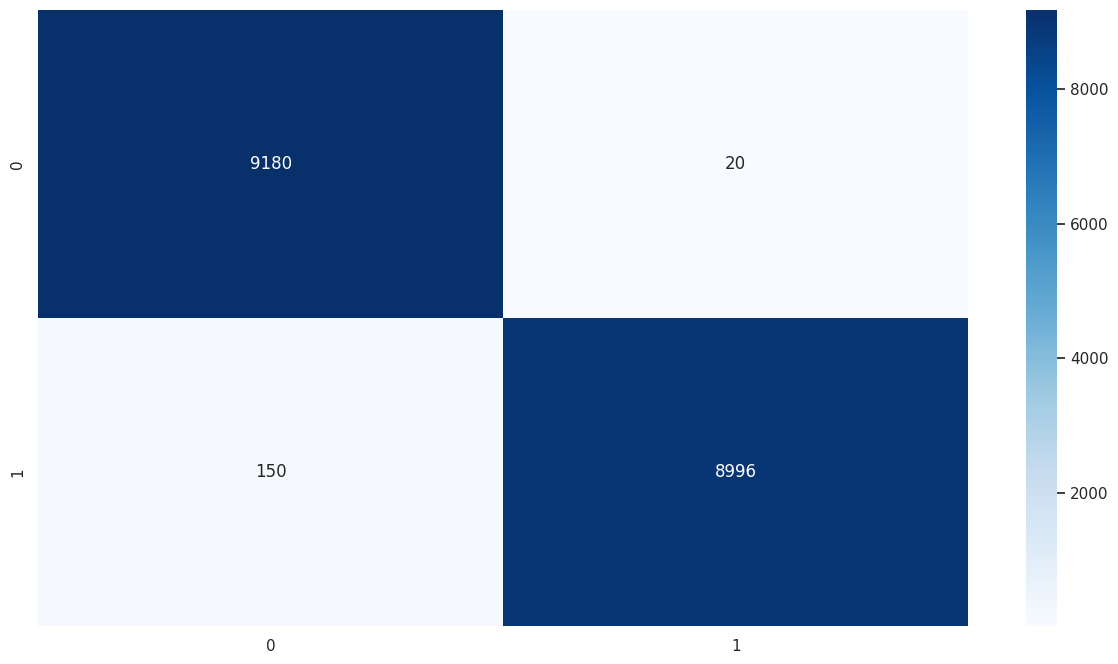

In [137]:
# Predictions and evaluation selected
y_pred = forest_important.predict(X_important_test)
ResultPrintout(forest_important)